In [ ]:
# import os
# import json
# import csv

# # Path to the directory containing JSON files
# json_directory = '/content/drive/MyDrive/SPRSound-main/train_json'

# # Output CSV file path
# csv_file_path = '/content/drive/MyDrive/SPRSound-main/train_record_annotations.csv'

# # Initialize a list to store the extracted record annotations
# record_annotations = []

# # Iterate over the JSON files in the directory
# for filename in os.listdir(json_directory):
#     if filename.endswith('.json'):
#         file_path = os.path.join(json_directory, filename)

#         # Load the JSON file
#         with open(file_path, 'r') as json_file:
#             data = json.load(json_file)

#         # Extract the record_annotation field
#         record_annotation = data.get('record_annotation')

#         # Append the record_annotation to the list
#         record_annotations.append(record_annotation)

# # Write the extracted record annotations to the CSV file
# with open(csv_file_path, 'w', newline='') as csv_file:
#     writer = csv.writer(csv_file)
#     writer.writerow(['File Name', 'Record Annotation'])

#     for filename, annotation in zip(os.listdir(json_directory), record_annotations):
#         filename = filename.replace('.json', '')  # Remove the ".json" extension
#         writer.writerow([filename, annotation])

# print('CSV file created successfully.')


In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import librosa
from sklearn import svm, naive_bayes, neighbors, ensemble
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import tensorflow_hub as hub
import librosa
from sklearn import naive_bayes, neighbors, ensemble, svm, tree, linear_model
import xgboost
import lightgbm
# import catboost
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression


In [ ]:
# Function to extract OpenL3 features from a WAV file
def extract_openl3_features(file_path):
    audio, sr = openl3.load_audio(file_path)
    emb, ts = openl3.get_audio_embedding(audio, sr, content_type="env")
    return np.mean(emb, axis=0)  # Taking the mean of OpenL3 embeddings



In [ ]:
# Function to extract MFCC features from a WAV file
def extract_mfcc_features(file_path):
    signal, sr = librosa.load(file_path)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    return np.mean(mfcc.T, axis=0)  # Taking the mean of MFCC coefficients



In [ ]:
# Function to extract log mel-scaled spectrogram features from a WAV file
def extract_log_mel_features(file_path):
    signal, sr = librosa.load(file_path)
    log_mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128, hop_length=512)
    log_mel = librosa.power_to_db(log_mel, ref=np.max)
    return np.mean(log_mel.T, axis=0)  # Taking the mean of log mel-scaled spectrogram coefficients


In [ ]:
# Function to extract mel-scaled spectrogram features from a WAV file
def extract_mel_features(file_path):
    signal, sr = librosa.load(file_path)
    mel = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128, hop_length=512)
    return np.mean(mel.T, axis=0)  # Taking the mean of mel-scaled spectrogram coefficients


In [ ]:
# Function to extract STFT features from a WAV file
def extract_stft_features(file_path):
    signal, sr = librosa.load(file_path)
    stft = np.abs(librosa.stft(signal))
    return np.mean(stft.T, axis=0)  # Taking the mean of STFT coefficients


In [ ]:
# Function to extract audio features from a WAV file
def extract_allfeatures_(file_path):
    signal, sr = librosa.load(file_path)

    # Extract different audio features
    # zcr = librosa.feature.zero_crossing_rate(signal).mean()
    # energy = np.sum(np.abs(signal)) / len(signal)
    # spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=signal, sr=sr))
    # spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=signal))
    # chroma = np.mean(librosa.feature.chroma_stft(y=signal, sr=sr))
    # tonnetz = np.mean(librosa.feature.tonnetz(y=signal, sr=sr))
    # spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=signal, sr=sr))
    # spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=signal, sr=sr))
    # spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=signal, sr=sr))
    mfcc_features = extract_mfcc_features(file_path)
    log_mel_features = extract_log_mel_features(file_path)
    mel_features = extract_mel_features(file_path)
    stft_features = extract_stft_features(file_path)

    # return [zcr, energy, spectral_contrast, spectral_flatness, chroma, tonnetz,
    #         spectral_centroid, spectral_rolloff, spectral_bandwidth]
    #       #    + \
    #       #  list(mfcc_features) + list(log_mel_features) + list(mel_features) + list(stft_features)

    return list(mfcc_features) + list(log_mel_features) + list(mel_features) + list(stft_features)



In [ ]:
# Load training data
train_wav_folder = '/content/drive/MyDrive/SPRSound-main/train_wav/'
train_annotations_file = '/content/drive/MyDrive/SPRSound-main/train_record_annotations.csv'

train_data = []
train_labels = []

annotations = pd.read_csv(train_annotations_file)
for index, row in annotations.iterrows():
    file_name = row['File Name']
    class_name = row['Record Annotation']
    file_path = train_wav_folder + file_name + '.wav'

    try:
        features =  extract_allfeatures_(file_path)
        train_data.append(features)
        train_labels.append(class_name)
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")

train_data = np.array(train_data)
train_labels = np.array(train_labels)


In [ ]:
# Load inter-patient test data
inter_test_wav_folder = '/content/drive/MyDrive/SPRSound-main/test_wav/'
inter_test_annotations_file = '/content/drive/MyDrive/SPRSound-main/inter_test_record_annotations.csv'

inter_test_data = []
inter_test_labels = []

inter_annotations = pd.read_csv(inter_test_annotations_file)
for index, row in inter_annotations.iterrows():
    file_name = row['File Name']
    class_name = row['Record Annotation']
    file_path = inter_test_wav_folder + file_name + '.wav'

    try:
        features = extract_allfeatures_(file_path)
        inter_test_data.append(features)
        inter_test_labels.append(class_name)
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")

inter_test_data = np.array(inter_test_data)
inter_test_labels = np.array(inter_test_labels)


In [ ]:
# Load intra-patient test data
intra_test_wav_folder = '/content/drive/MyDrive/SPRSound-main/test_wav/'
intra_test_annotations_file = '/content/drive/MyDrive/SPRSound-main/intra_test_record_annotations.csv'

intra_test_data = []
intra_test_labels = []

intra_annotations = pd.read_csv(intra_test_annotations_file)
for index, row in intra_annotations.iterrows():
    file_name = row['File Name']
    class_name = row['Record Annotation']
    file_path = intra_test_wav_folder + file_name + '.wav'

    try:
        features = extract_allfeatures_(file_path)
        intra_test_data.append(features)
        intra_test_labels.append(class_name)
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")

intra_test_data = np.array(intra_test_data)
intra_test_labels = np.array(intra_test_labels)

In [ ]:
# Classification using SVM
svm_classifier = svm.SVC()
svm_classifier.fit(train_data, train_labels)
svm_inter_pred = svm_classifier.predict(inter_test_data)
svm_intra_pred = svm_classifier.predict(intra_test_data)

In [ ]:
# Classification using Naive Bayes
nb_classifier = naive_bayes.GaussianNB()
nb_classifier.fit(train_data, train_labels)
nb_inter_pred = nb_classifier.predict(inter_test_data)
nb_intra_pred = nb_classifier.predict(intra_test_data)

# Classification using K-Nearest Neighbors
knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(train_data, train_labels)
knn_inter_pred = knn_classifier.predict(inter_test_data)
knn_intra_pred = knn_classifier.predict(intra_test_data)

# Classification using Random Forest
rf_classifier = ensemble.RandomForestClassifier()
rf_classifier.fit(train_data, train_labels)
rf_inter_pred = rf_classifier.predict(inter_test_data)
rf_intra_pred = rf_classifier.predict(intra_test_data)

# Classification using Decision Trees
dt_classifier = tree.DecisionTreeClassifier()
dt_classifier.fit(train_data, train_labels)
dt_inter_pred = dt_classifier.predict(inter_test_data)
dt_intra_pred = dt_classifier.predict(intra_test_data)

# Classification using Logistic Regression
lr_classifier = linear_model.LogisticRegression()
lr_classifier.fit(train_data, train_labels)
lr_inter_pred = lr_classifier.predict(inter_test_data)
lr_intra_pred = lr_classifier.predict(intra_test_data)

# Classification using AdaBoost
ab_classifier = ensemble.AdaBoostClassifier()
ab_classifier.fit(train_data, train_labels)
ab_inter_pred = ab_classifier.predict(inter_test_data)
ab_intra_pred = ab_classifier.predict(intra_test_data)

# # Classification using Gradient Boosting
# gb_classifier = ensemble.GradientBoostingClassifier()
# gb_classifier.fit(train_data, train_labels)
# gb_inter_pred = gb_classifier.predict(inter_test_data)
# gb_intra_pred = gb_classifier.predict(intra_test_data)

# Classification using Extra Trees
et_classifier = ensemble.ExtraTreesClassifier()
et_classifier.fit(train_data, train_labels)
et_inter_pred = et_classifier.predict(inter_test_data)
et_intra_pred = et_classifier.predict(intra_test_data)

# # Classification using XGBoost
# xgb_classifier = xgboost.XGBClassifier()
# xgb_classifier.fit(train_data, train_labels)
# xgb_inter_pred = xgb_classifier.predict(inter_test_data)
# xgb_intra_pred = xgb_classifier.predict(intra_test_data)

# Classification using LightGBM
lgbm_classifier = lightgbm.LGBMClassifier()
lgbm_classifier.fit(train_data, train_labels)
lgbm_inter_pred = lgbm_classifier.predict(inter_test_data)
lgbm_intra_pred = lgbm_classifier.predict(intra_test_data)


# Classification using MLP (Multi-Layer Perceptron)
mlp_classifier = MLPClassifier()
mlp_classifier.fit(train_data, train_labels)
mlp_inter_pred = mlp_classifier.predict(inter_test_data)
mlp_intra_pred = mlp_classifier.predict(intra_test_data)

# Classification using Linear Discriminant Analysis (LDA)
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(train_data, train_labels)
lda_inter_pred = lda_classifier.predict(inter_test_data)
lda_intra_pred = lda_classifier.predict(intra_test_data)

# # Classification using Gradient Boosting Classifier
# gbc_classifier = GradientBoostingClassifier()
# gbc_classifier.fit(train_data, train_labels)
# gbc_inter_pred = gbc_classifier.predict(inter_test_data)
# gbc_intra_pred = gbc_classifier.predict(intra_test_data)

# Classification using AdaBoost Classifier
abc_classifier = AdaBoostClassifier()
abc_classifier.fit(train_data, train_labels)
abc_inter_pred = abc_classifier.predict(inter_test_data)
abc_intra_pred = abc_classifier.predict(intra_test_data)

# Classification using Logistic Regression Classifier
lr_classifier = LogisticRegression()
lr_classifier.fit(train_data, train_labels)
lr_inter_pred = lr_classifier.predict(inter_test_data)
lr_intra_pred = lr_classifier.predict(intra_test_data)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
# Print classification reports
print("Inter-patient Classification Reports:")
print("SVM Classifier:")
print(classification_report(inter_test_labels, svm_inter_pred))
print("Naive Bayes Classifier:")
print(classification_report(inter_test_labels, nb_inter_pred))
print("K-Nearest Neighbors Classifier:")
print(classification_report(inter_test_labels, knn_inter_pred))
print("Random Forest Classifier:")
print(classification_report(inter_test_labels, rf_inter_pred))
print("Decision Trees Classifier:")
print(classification_report(inter_test_labels, dt_inter_pred))
print("Logistic Regression Classifier:")
print(classification_report(inter_test_labels, lr_inter_pred))
print("AdaBoost Classifier:")
print(classification_report(inter_test_labels, ab_inter_pred))
# print("Gradient Boosting Classifier:")
# print(classification_report(inter_test_labels, gb_inter_pred))
print("Extra Trees Classifier:")
print(classification_report(inter_test_labels, et_inter_pred))
print("LightGBM Classifier:")
print(classification_report(inter_test_labels, lgbm_inter_pred))
print("MLP (Multi-Layer Perceptron) Classifier:")
print(classification_report(inter_test_labels, mlp_inter_pred))
print("Linear Discriminant Analysis (LDA) Classifier:")
print(classification_report(inter_test_labels, lda_inter_pred))
print("AdaBoost Classifier Classifier:")
print(classification_report(inter_test_labels, abc_inter_pred))



print("Intra-patient Classification Reports:")
print("SVM Classifier:")
print(classification_report(intra_test_labels, svm_intra_pred))
print("Naive Bayes Classifier:")
print(classification_report(intra_test_labels, nb_intra_pred))
print("K-Nearest Neighbors Classifier:")
print(classification_report(intra_test_labels, knn_intra_pred))
print("Random Forest Classifier:")
print(classification_report(intra_test_labels, rf_intra_pred))
print("Decision Trees Classifier:")
print(classification_report(intra_test_labels, dt_intra_pred))
print("Logistic Regression Classifier:")
print(classification_report(intra_test_labels, lr_intra_pred))
print("AdaBoost Classifier:")
print(classification_report(intra_test_labels, ab_intra_pred))
# print("Gradient Boosting Classifier:")
# print(classification_report(intra_test_labels, gb_intra_pred))
print("Extra Trees Classifier:")
print(classification_report(intra_test_labels, et_intra_pred))
print("LightGBM Classifier:")
print(classification_report(intra_test_labels, lgbm_intra_pred))
print("MLP (Multi-Layer Perceptron) Classifier:")
print(classification_report(intra_test_labels, mlp_intra_pred))
print("Linear Discriminant Analysis (LDA) Classifier:")
print(classification_report(intra_test_labels, lda_intra_pred))
print("AdaBoost Classifier Classifier:")
print(classification_report(intra_test_labels, abc_intra_pred))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Inter-patient Classification Reports:
SVM Classifier:
              precision    recall  f1-score   support

         CAS       0.00      0.00      0.00        65
   CAS & DAS       0.00      0.00      0.00        17
         DAS       0.00      0.00      0.00        24
      Normal       0.68      1.00      0.81       241
Poor Quality       0.00      0.00      0.00         8

    accuracy                           0.68       355
   macro avg       0.14      0.20      0.16       355
weighted avg       0.46      0.68      0.55       355

Naive Bayes Classifier:
              precision    recall  f1-score   support

         CAS       0.29      0.03      0.06        65
   CAS & DAS       0.08      0.59      0.15        17
         DAS       0.04      0.38      0.08        24
      Normal       0.00      0.00      0.00       241
Poor Quality       0.00      0.00      0.00         8

    accuracy                           0.06       355
   macro avg       0.08      0.20      0.06       355

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

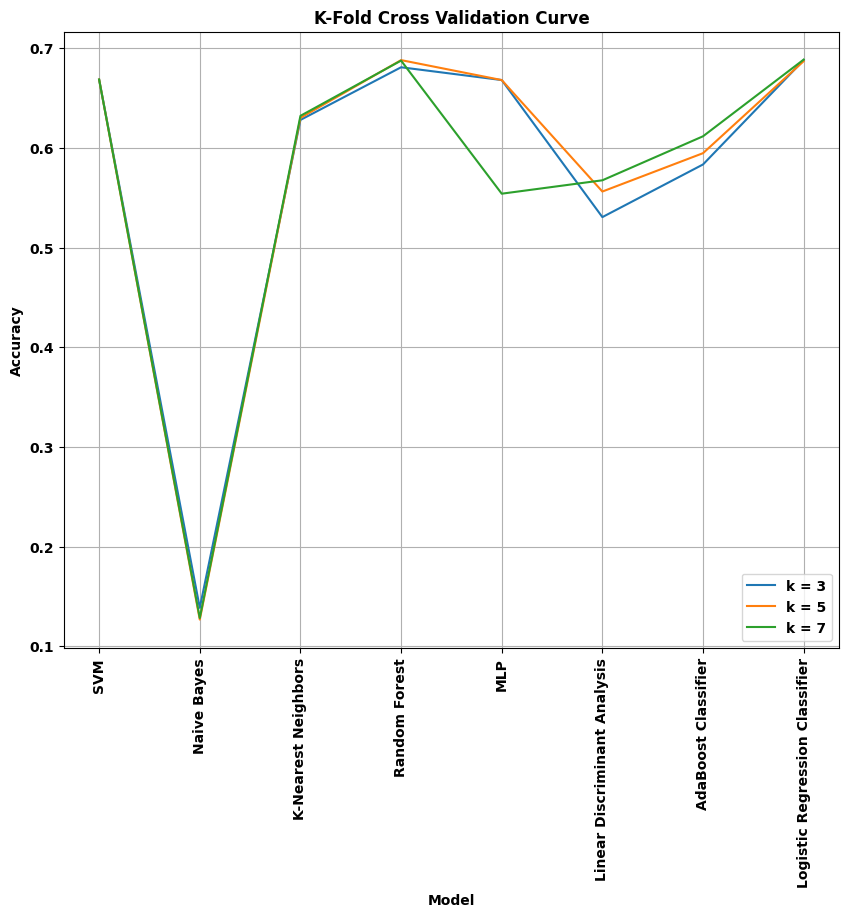

In [ ]:
from sklearn.model_selection import cross_val_score

k_values = [3, 5, 7]
models = [
    ('SVM', svm_classifier),
    ('Naive Bayes', nb_classifier),
    ('K-Nearest Neighbors', knn_classifier),
    ('Random Forest', rf_classifier),
    ('MLP', mlp_classifier),
    ('Linear Discriminant Analysis', lda_classifier),
    ('AdaBoost Classifier', abc_classifier),
    ('Logistic Regression Classifier', lr_classifier)
]



plt.figure(figsize=(10, 8))

for k in k_values:
    scores = []
    for model_name, model in models:
        cv_scores = cross_val_score(model, train_data, train_labels, cv=k)
        scores.append(cv_scores.mean())

    plt.plot([name for name, _ in models], scores, label=f'k = {k}')

plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('K-Fold Cross Validation Curve', fontweight='bold')
plt.legend(loc='lower right', prop={'weight': 'bold'})
plt.grid(True)

# Bold y-axis and x-axis values
plt.xticks(rotation='vertical')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.show()



In [ ]:
import csv

# Create a list to store the accuracy values for each model and k value
accuracy_values = []

# Perform k-fold cross-validation for each k value
for k in k_values:
    scores = []
    for model_name, model in models:
        cv_scores = cross_val_score(model, train_data, train_labels, cv=k)
        scores.append(cv_scores.mean())
    accuracy_values.append((k, scores))

# Save the accuracy values to a CSV file
csv_file = 'accuracy_values_extract_allfeatures_.csv'
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['k', 'Model', 'Accuracy'])
    for k, scores in accuracy_values:
        for model_name, accuracy in zip([name for name, _ in models], scores):
            writer.writerow([k, model_name, accuracy])

print(f"Accuracy values saved to '{csv_file}'.")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy values saved to 'accuracy_values_extract_allfeatures_.csv'.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.ensemble import VotingClassifier

# Create the ensemble network
ensemble_classifier = VotingClassifier(
    estimators=[
        ('SVM', svm_classifier),
        ('Naive Bayes', nb_classifier),
        ('K-Nearest Neighbors', knn_classifier),
        ('Random Forest', rf_classifier),
        ('MLP', mlp_classifier),
        ('LDA', lda_classifier),
        ('AdaBoost', abc_classifier),
        ('Logistic Regression', lr_classifier),
        ('Extra Tree', et_classifier)
    ],
    voting='hard'  # Use majority voting
)

# Train the ensemble network
ensemble_classifier.fit(train_data, train_labels)

# Make predictions using the ensemble network
ensemble_inter_pred = ensemble_classifier.predict(inter_test_data)
ensemble_intra_pred = ensemble_classifier.predict(intra_test_data)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("ensemble_classifier Classifier:")
print(classification_report(inter_test_labels, ensemble_inter_pred))
print(classification_report(intra_test_labels, ensemble_intra_pred))

ensemble_classifier Classifier:
              precision    recall  f1-score   support

         CAS       0.55      0.26      0.35        65
   CAS & DAS       0.15      0.24      0.18        17
         DAS       0.00      0.00      0.00        24
      Normal       0.78      0.93      0.85       241
Poor Quality       0.18      0.25      0.21         8

    accuracy                           0.69       355
   macro avg       0.33      0.33      0.32       355
weighted avg       0.64      0.69      0.65       355

              precision    recall  f1-score   support

         CAS       0.60      0.21      0.32        42
   CAS & DAS       0.29      0.11      0.15        19
         DAS       0.00      0.00      0.00        75
      Normal       0.66      0.97      0.79       241
Poor Quality       0.20      0.50      0.29         2

    accuracy                           0.65       379
   macro avg       0.35      0.36      0.31       379
weighted avg       0.50      0.65      0.55  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
print(f"\n{k}-fold Cross-validation Scores:")
print("SVM Classifier:", svm_scores)
print("Naive Bayes Classifier:", nb_scores)
print("K-Nearest Neighbors Classifier:", knn_scores)
print("Random Forest Classifier:", rf_scores)
print("MLP Classifier:", mlp_scores)
print("LDA Classifier:", lda_scores)
print("AdaBoost Classifier:", abc_scores)
print("Logistic Regression Classifier:", lr_scores)



5-fold Cross-validation Scores:
SVM Classifier: [0.6692307692307692, 0.6692307692307692, 0.6692307692307692, 0.6666666666666666, 0.6683804627249358]
Naive Bayes Classifier: [0.5820512820512821, 0.6256410256410256, 0.6282051282051282, 0.5897435897435898, 0.5809768637532133]
K-Nearest Neighbors Classifier: [0.6, 0.6410256410256411, 0.6153846153846154, 0.6256410256410256, 0.6323907455012854]
Random Forest Classifier: [0.6820512820512821, 0.6564102564102564, 0.6794871794871795, 0.6487179487179487, 0.6529562982005142]
MLP Classifier: [0.6794871794871795, 0.6666666666666666, 0.6794871794871795, 0.6564102564102564, 0.6812339331619537]
LDA Classifier: [0.6846153846153846, 0.6794871794871795, 0.6897435897435897, 0.6615384615384615, 0.6889460154241646]
Gradient Boosting Classifier: [0.6820512820512821, 0.6794871794871795, 0.676923076923077, 0.6410256410256411, 0.6735218508997429]
AdaBoost Classifier: [0.6435897435897436, 0.6538461538461539, 0.6666666666666666, 0.6512820512820513, 0.650385604113

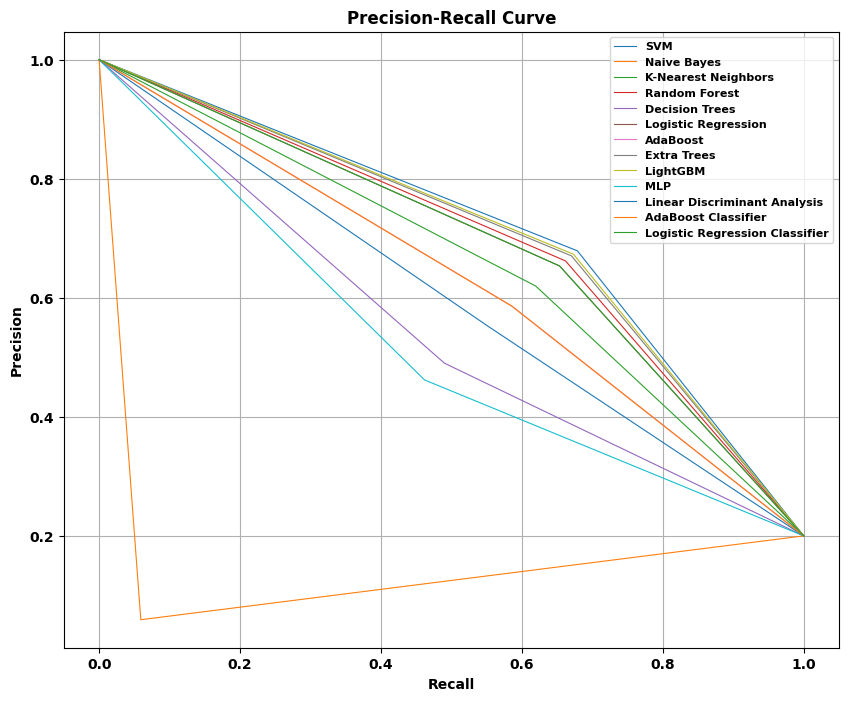

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Define the models and their corresponding predictions
models = [
    ('SVM', svm_inter_pred),
    ('Naive Bayes', nb_inter_pred),
    ('K-Nearest Neighbors', knn_inter_pred),
    ('Random Forest', rf_inter_pred),
    ('Decision Trees', dt_inter_pred),
    ('Logistic Regression', lr_inter_pred),
    ('AdaBoost', ab_inter_pred),
    ('Extra Trees', et_inter_pred),
    ('LightGBM', lgbm_inter_pred),
    ('MLP', mlp_inter_pred),
    ('Linear Discriminant Analysis', lda_inter_pred),
    ('AdaBoost Classifier', abc_inter_pred),
    ('Logistic Regression Classifier', lr_inter_pred)
]

# Convert labels and predictions to binary format
classes = np.unique(inter_test_labels)
inter_test_labels_bin = label_binarize(inter_test_labels, classes=classes)
models_bin = [(name, label_binarize(pred, classes=classes)) for name, pred in models]

# Calculate precision and recall for each model
plt.figure(figsize=(10, 8))
for (model_name, model_pred), (model_name_bin, model_pred_bin) in zip(models, models_bin):
    precision, recall, _ = precision_recall_curve(inter_test_labels_bin.ravel(), model_pred_bin.ravel())
    average_precision = average_precision_score(inter_test_labels_bin.ravel(), model_pred_bin.ravel())
    plt.plot(recall, precision, label=f'{model_name}', linewidth=0.8)

# Plot Precision-Recall Curve
plt.xlabel('Recall', fontweight='bold')
plt.ylabel('Precision', fontweight='bold')
plt.title('Precision-Recall Curve', fontweight='bold')
plt.legend(loc='upper right', prop={'weight': 'bold', 'size': 8})
plt.grid(True)
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()


In [ ]:
import csv

# Create a list to store the precision and recall values for each model
precision_recall_values = []

# Calculate precision and recall for each model
for (model_name, model_pred), (model_name_bin, model_pred_bin) in zip(models, models_bin):
    precision, recall, _ = precision_recall_curve(inter_test_labels_bin.ravel(), model_pred_bin.ravel())
    average_precision = average_precision_score(inter_test_labels_bin.ravel(), model_pred_bin.ravel())
    precision_recall_values.append((model_name, precision, recall, average_precision))

# Save the precision and recall values to a CSV file
csv_file = 'precision_recall_values_extract_allfeatures_.csv'
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Model', 'Precision', 'Recall', 'Average Precision'])
    for model_name, precision, recall, average_precision in precision_recall_values:
        for p, r in zip(precision, recall):
            writer.writerow([model_name, p, r, average_precision])

print(f"Precision and recall values saved to '{csv_file}'.")


Precision and recall values saved to 'precision_recall_values_extract_allfeatures_.csv'.


In [ ]:
import os
import csv
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Reshape, Permute
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.mobilenet_v2 import MobileNetV2



In [ ]:
# Define the paths
train_wav_path = '/content/drive/MyDrive/SPRSound-main/train_wav'
train_csv_path = '/content/drive/MyDrive/SPRSound-main/train_record_annotations.csv'
test_wav_path = '/content/drive/MyDrive/SPRSound-main/test_wav'
inter_test_csv_path = '/content/drive/MyDrive/SPRSound-main/inter_test_record_annotations.csv'
intra_test_csv_path = '/content/drive/MyDrive/SPRSound-main/intra_test_record_annotations.csv'


In [ ]:
# Define the fixed length for padding/truncation
fixed_length = 128

In [ ]:
# Function to load and process audio files
def process_audio(file_path):
    waveform, sample_rate = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    return log_mel_spec


In [ ]:
# Function to load and process the training data
def load_training_data():
    X = []
    y = []
    max_length = 0  # To track the maximum length of spectrogram
    with open(train_csv_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)  # Skip header
        for row in csv_reader:
            file_name = row[0] + '.wav'
            class_name = row[1]
            file_path = os.path.join(train_wav_path, file_name)
            log_mel_spec = process_audio(file_path)
            X.append(log_mel_spec)
            y.append(class_name)
            if log_mel_spec.shape[1] > max_length:
                max_length = log_mel_spec.shape[1]
    print("Maximum spectrogram length:", max_length)
    return X, y, max_length


In [ ]:
# Function to load and process the testing data
def load_testing_data(test_csv_path):
    X = []
    y = []
    with open(test_csv_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)  # Skip header
        for row in csv_reader:
            file_name = row[0] + '.wav'
            class_name = row[1]
            file_path = os.path.join(test_wav_path, file_name)
            log_mel_spec = process_audio(file_path)
            X.append(log_mel_spec)
            y.append(class_name)
    return X, y

In [ ]:
# Load the training data
X_train, y_train, max_length = load_training_data()

# Load the inter-test data
X_inter_test, y_inter_test = load_testing_data(inter_test_csv_path)

# Load the intra-test data
X_intra_test, y_intra_test = load_testing_data(intra_test_csv_path)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



Maximum spectrogram length: 241


In [ ]:
# Pad or truncate the spectrograms to the maximum length
fixed_length = max_length
for i in range(len(X_train)):
    if X_train[i].shape[1] < fixed_length:
        X_train[i] = np.pad(X_train[i], ((0, 0), (0, fixed_length - X_train[i].shape[1])), mode='constant')
    elif X_train[i].shape[1] > fixed_length:
        X_train[i] = X_train[i][:, :fixed_length]

for i in range(len(X_val)):
    if X_val[i].shape[1] < fixed_length:
        X_val[i] = np.pad(X_val[i], ((0, 0), (0, fixed_length - X_val[i].shape[1])), mode='constant')
    elif X_val[i].shape[1] > fixed_length:
        X_val[i] = X_val[i][:, :fixed_length]

for i in range(len(X_inter_test)):
    if X_inter_test[i].shape[1] < fixed_length:
        X_inter_test[i] = np.pad(X_inter_test[i], ((0, 0), (0, fixed_length - X_inter_test[i].shape[1])), mode='constant')
    elif X_inter_test[i].shape[1] > fixed_length:
        X_inter_test[i] = X_inter_test[i][:, :fixed_length]

for i in range(len(X_intra_test)):
    if X_intra_test[i].shape[1] < fixed_length:
        X_intra_test[i] = np.pad(X_intra_test[i], ((0, 0), (0, fixed_length - X_intra_test[i].shape[1])), mode='constant')
    elif X_intra_test[i].shape[1] > fixed_length:
        X_intra_test[i] = X_intra_test[i][:, :fixed_length]






In [ ]:
# Convert the data to NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_inter_test = np.array(X_inter_test)
X_intra_test = np.array(X_intra_test)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reshape the data for VGG-16
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_inter_test = np.expand_dims(X_inter_test, axis=-1)
X_intra_test = np.expand_dims(X_intra_test, axis=-1)




In [ ]:
# Convert class names to categorical labels
class_names = np.unique(y_train)
num_classes = len(class_names)
class_to_label = {class_name: label for label, class_name in enumerate(class_names)}
label_to_class = {label: class_name for class_name, label in class_to_label.items()}
y_train = np.array([class_to_label[class_name] for class_name in y_train])
y_val = np.array([class_to_label[class_name] for class_name in y_val])
y_inter_test = np.array([class_to_label[class_name] for class_name in y_inter_test])
y_intra_test = np.array([class_to_label[class_name] for class_name in y_intra_test])


In [ ]:
# Normalize the data
X_train = X_train / np.max(X_train)
X_val = X_val / np.max(X_val)
X_inter_test = X_inter_test / np.max(X_inter_test)
X_intra_test = X_intra_test / np.max(X_intra_test)





In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import GRU



In [ ]:
# Scaled Dot-Product Attention
def scaled_dot_product_attention(Q, K, V, mask=None):
    # Calculate the dot product of query and key
    matmul_qk = tf.matmul(Q, K, transpose_b=True)

    # Scale the dot product
    dk = tf.cast(tf.shape(K)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # Apply the mask (if provided)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # Apply softmax to get the attention weights
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # Multiply the attention weights with the value
    output = tf.matmul(attention_weights, V)

    return output, attention_weights

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.Wq = tf.keras.layers.Dense(units)
        self.Wk = tf.keras.layers.Dense(units)
        self.Wv = tf.keras.layers.Dense(units)
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, inputs):
        Q = self.Wq(inputs)  # Query
        K = self.Wk(inputs)  # Key
        V = self.Wv(inputs)  # Value

        attention_weights = tf.matmul(Q, K, transpose_b=True)
        attention_weights = self.softmax(attention_weights)

        output = tf.matmul(attention_weights, V)
        return output


In [ ]:
# base_model = VGG16(weights=weights_path, include_top=False, input_shape=(128, 241, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 241, 3))
# base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 241, 3))
# base_model_2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(128, 241, 3))
# base_model = tf.keras.applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=(128, 241, 3))



model1 = Sequential()


model1.add(Reshape((128, 241, 1), input_shape=(128, 241, 1)))
model1.add(tf.keras.layers.Lambda(lambda x: tf.tile(x, [1, 1, 1, 3])))


model1.add(base_model)
model1.add(Flatten())


model1.add(Dense(4096, activation='relu'))
model1.add(Dropout(0.7))
model1.add(Dense(4096, activation='relu'))
model1.add(Dropout(0.7))
model1.add(SelfAttention(units=64))



model1.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)))  # Expand dimensions

model1.add(tf.keras.layers.Lambda(lambda x: tf.squeeze(x, axis=-1)))  # Squeeze the dimensions

model1.add(Flatten())  # Flatten the output

model1.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=2)))  # Expand dimensions

model1.add(tf.keras.layers.Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1])))  # Transpose the dimensions

model1.add(Flatten())  # Flatten the output

model1.add(Dense(num_classes, activation='softmax'))



94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 128, 241, 1)       0         
                                                                 
 lambda_5 (Lambda)           (None, 128, 241, 3)       0         
                                                                 
 resnet101v2 (Functional)    (None, 4, 8, 2048)        42626560  
                                                                 
 flatten_3 (Flatten)         (None, 65536)             0         
                                                                 
 dense_3 (Dense)             (None, 4096)              268439552 
                                                                 
 dropout_2 (Dropout)         (None, 4096)              0         
                                                                 
 dense_4 (Dense)             (None, 4096)             

In [ ]:
# Compile and train the model
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model1.fit(X_train, y_train, validation_data=(X_val, y_train), epochs=21, batch_size=32)



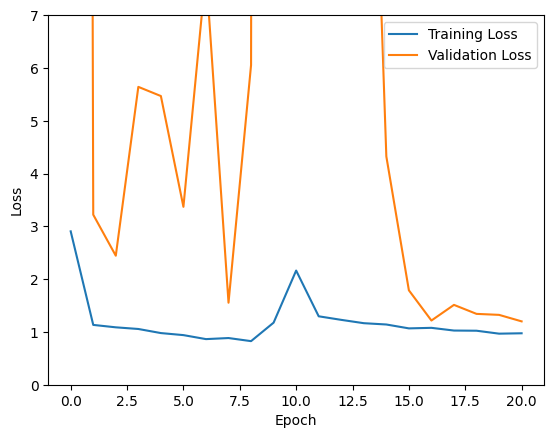

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss vs. epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,7)  # Adjust the y-axis limits as per your requirement
plt.show()


In [ ]:
# Evaluate the model on inter-test and intra-test data
inter_test_loss, inter_test_accuracy = model1.evaluate(X_inter_test, y_inter_test)
intra_test_loss, intra_test_accuracy = model1.evaluate(X_intra_test, y_intra_test)

print('Inter-Test Accuracy:', inter_test_accuracy)
print('Intra-Test Accuracy:', intra_test_accuracy)

12/12 [==============================] - 2s 179ms/step - loss: 1.2934 - accuracy: 0.6359
Inter-Test Accuracy: 0.6788732409477234
Intra-Test Accuracy: 0.6358839273452759
